In [1]:
import sys
print(sys.executable)

/home/haoying/anaconda3/envs/torch/bin/python


In [2]:
from utils import create_space
import pandas as pd
import numpy as np
import os
import random
import geoio
import convert as conv

In [3]:
images = os.listdir('/home/haoying/data_zl12/')

In [4]:
data = pd.DataFrame()
data['name'] = images

data['cluster_lat'] = [conv.num2deg(conv.deg2num(float(x.strip('.png').split('_')[1]),float(x.strip('.png').split('_')[0]),12)[1],conv.deg2num(float(x.strip('.png').split('_')[1]),float(x.strip('.png').split('_')[0]),12)[0],12)[0] for x in images]
data['cluster_lon'] = [conv.num2deg(conv.deg2num(float(x.strip('.png').split('_')[1]),float(x.strip('.png').split('_')[0]),12)[1],conv.deg2num(float(x.strip('.png').split('_')[1]),float(x.strip('.png').split('_')[0]),12)[0],12)[1] for x in images]

In [5]:
data

,name,cluster_lat,cluster_lon
0,-48.779296875_-66.93006025862447.png,43.771094,90.966797
1,-44.82421875_-75.97355295343337.png,40.847060,120.058594
2,-44.82421875_-70.98834922412489.png,40.847060,102.304688
3,-39.111328125_-65.4034447883078.png,36.385913,87.275391
4,-50.80078125_-77.86034459764656.png,45.213004,128.320312
...,...,...,...
131947,-38.671875_-69.28725695167886.png,36.031332,97.382812
131948,-46.142578125_-72.63337363853837.png,41.836828,107.666016
131949,-44.208984375_-66.08936427047087.png,40.380028,88.945312
131950,-25.224609375_-74.59010800882324.png,24.447150,114.609375


In [6]:
NIGHTLIGHTS_DIR = '/home/haoying/VNL_v2_npp_2020_global_vcmslcfg_c202101211500.average.tif'
tif = geoio.GeoImage(NIGHTLIGHTS_DIR)
tif_array = np.squeeze(tif.get_data())

In [7]:
def add_nightlights(df, tif, tif_array):
    ''' 
    This takes a dataframe with columns cluster_lat, cluster_lon and finds the average 
    nightlights in 2015 using a 10kmx10km box around the point
    
    I try all the nighlights tifs until a match is found, or none are left upon which an error is raised
    '''
    cluster_nightlights = []
    for i,r in df.iterrows():
        min_lat, min_lon, max_lat, max_lon = create_space(r.cluster_lat, r.cluster_lon,s=9.7)
        
        xminPixel, ymaxPixel = tif.proj_to_raster(min_lon, min_lat)
        xmaxPixel, yminPixel = tif.proj_to_raster(max_lon, max_lat)
        assert xminPixel < xmaxPixel, print(r.cluster_lat, r.cluster_lon)
        assert yminPixel < ymaxPixel, print(r.cluster_lat, r.cluster_lon)
        if xminPixel < 0 or xmaxPixel >= tif_array.shape[1]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        elif yminPixel < 0 or ymaxPixel >= tif_array.shape[0]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        xminPixel, yminPixel, xmaxPixel, ymaxPixel = int(xminPixel), int(yminPixel), int(xmaxPixel), int(ymaxPixel)
        cluster_nightlights.append(tif_array[yminPixel:ymaxPixel,xminPixel:xmaxPixel].mean())
        
    df['nightlights'] = cluster_nightlights

In [8]:
add_nightlights(data, tif, tif_array)

In [9]:
data.head()

,name,cluster_lat,cluster_lon,nightlights
0,-48.779296875_-66.93006025862447.png,43.771094,90.966797,0.377887
1,-44.82421875_-75.97355295343337.png,40.847060,120.058594,0.398727
2,-44.82421875_-70.98834922412489.png,40.847060,102.304688,0.272418
3,-39.111328125_-65.4034447883078.png,36.385913,87.275391,0.388664
4,-50.80078125_-77.86034459764656.png,45.213004,128.320312,0.308112


In [10]:
data[['cluster_lon','cluster_lat']].to_csv('/home/haoying/res_zl12_effnet_b0_9.7km/position.csv',index=False,encoding='utf_8_sig')

In [11]:
data.to_csv('/home/haoying/res_zl12_effnet_b0_9.7km/nightlights.csv',index=False)

In [12]:
data.columns=['y_x','cluster_lat','cluster_lon','nightlights']

In [1]:
import math
import random
import os
import numpy as np
import pandas as pd
from osgeo import gdal, osr

import requests
#import matplotlib.pyplot as plt
from io import BytesIO
import logging
import time

In [2]:
data = pd.read_csv('/home/haoying/res_zl12_effnet_b0_9.7km/nightlights.csv')
data.columns=['y_x','cluster_lat','cluster_lon','nightlights']

In [3]:
print(len(data))
np.percentile(data['nightlights'], 97.5)

131952


3.046055

In [4]:
max95 = np.percentile(data['nightlights'], 97.5)
min5 = np.percentile(data['nightlights'], 2.5)
data = data[(data['nightlights']<max95)&(data['nightlights']>min5)]
len(data)

125353

In [5]:
from sklearn.mixture import GaussianMixture as GMM
X = data['nightlights'].values.reshape(-1,1)
gmm = GMM(n_components=3).fit(X)
labels = gmm.predict(data['nightlights'].values.reshape(-1,1))

n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

Text(0.5, 0, 'n_components')

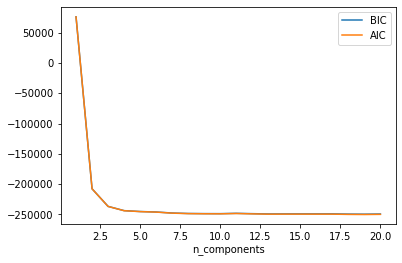

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

In [7]:
label0_max = data['nightlights'][labels==0].max()
label1_max = data['nightlights'][labels==1].max()
label2_max = data['nightlights'][labels==2].max()

label0_max, label1_max, label2_max

(0.39044592, 3.0458412, 0.7466203)

In [8]:
def create_nightlights_bin(df, cutoffs):
    assert len(cutoffs) >= 2, print('need at least 2 bins')
    cutoffs = sorted(cutoffs, reverse=True)
    labels = list(range(len(cutoffs)))[::-1]
    df['nightlights_bin'] = len(cutoffs)
    for cutoff, label in zip(cutoffs, labels):
        df['nightlights_bin'].loc[df['nightlights'] <= cutoff] = label

data_final = data.copy()
create_nightlights_bin(data_final, cutoffs=[label0_max, label1_max, label2_max])
data_final['nightlights_bin'].value_counts()/len(data_final)

/home/haoying/anaconda3/envs/torch/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0    0.752156
1    0.172952
2    0.074893
Name: nightlights_bin, dtype: float64

In [9]:
RANDOM_SEED=1
MIN_IMAGES_PER_CLUSTER=10
def drop_in_range(df, lower=0, upper=2, fr=0.25):
    """
        Very similar to drop_0s calculation, but more generalized. Lower and upper are inclusive.
    """
    np.random.seed(RANDOM_SEED)
    boolean_idx = ((lower <= df['nightlights']) & (df['nightlights'] <= upper))
    c_under = boolean_idx.sum()
    n = len(df)
    assert c_under / n > fr, print(f'Dataframe already has under {fr} rows in the given range')
    
    d = (c_under - n * fr) / (1 - fr)
    d = int(d)
    print(f'dropping: {d}')
    
    select_df = df[boolean_idx]
    
    
    drop_inds = random.sample(select_df.index.tolist(), d)
        
    return df.drop(drop_inds).reset_index(drop=True)

In [17]:
data_drop2 = drop_in_range(data, lower=0, upper=0.39, fr=0.2)
len(data_drop2)

dropping: 86387


38966

In [18]:
(data_drop2['nightlights']<0.39).sum()/len(data_drop2['nightlights'])

0.20002053071908843

In [12]:
(data_drop2['nightlights']<1).sum()/len(data_drop2['nightlights'])

0.854726559680485

In [19]:
data_drop2[['cluster_lon','cluster_lat']].to_csv('/home/haoying/res_zl12_effnet_b0_9.7km/position_drop.csv',index=False,encoding='utf_8_sig')
data_drop2.to_csv('/home/haoying/res_zl12_effnet_b0_9.7km/nightlights_drop.csv',index=False)

In [35]:
# label0_max = data_drop2['nightlights'][labels==0].max()
# label1_max = data_drop2['nightlights'][labels==1].max()
# label2_max = data_drop2['nightlights'][labels==2].max()

# label0_max, label1_max, label2_max

In [20]:
label0_max = 0.39
label1_max = 0.74
label2_max = 3.1

In [21]:
data_final = data_drop2.copy()
create_nightlights_bin(data_final, cutoffs=[label0_max, label1_max, label2_max])

In [22]:
data_final['nightlights_bin'].value_counts()/len(data_final)

1    0.556177
2    0.243802
0    0.200021
Name: nightlights_bin, dtype: float64

In [23]:
data_final.to_csv('/home/haoying/res_zl12_effnet_b0_9.7km/nightlights_labeled.csv', index = False)

In [32]:
data_final[data_final['nightlights_bin'] == 0].to_csv('/home/haoying/res_zl12_effnet_b0_9.7km/nightlights_labeled0.csv', index = False)
data_final[data_final['nightlights_bin'] == 1].to_csv('/home/haoying/res_zl12_effnet_b0_9.7km/nightlights_labeled1.csv', index = False)
data_final[data_final['nightlights_bin'] == 2].to_csv('/home/haoying/res_zl12_effnet_b0_9.7km/nightlights_labeled2.csv', index = False)

In [1]:
from utils import create_space
import pandas as pd
import numpy as np
import os
import random
import geoio
import convert as conv
data_final0 = pd.read_csv('/home/haoying/res_zl12_effnet_b0_9.7km/nightlights_labeled0.csv')
data_final1 = pd.read_csv('/home/haoying/res_zl12_effnet_b0_9.7km/nightlights_labeled1.csv')
data_final2 = pd.read_csv('/home/haoying/res_zl12_effnet_b0_9.7km/nightlights_labeled2.csv')

In [2]:
images = ['/home/haoying/data_zl12/' + x for x in data_final2['y_x'].tolist()]
labels = data_final2['nightlights'].tolist()

In [3]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
#import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
from skimage import io,transform
from PIL import Image
import os
import numpy as np
import random
import cv2 as cv

In [4]:
class Data(Dataset): #继承Dataset
    def __init__(self,transform=None): #__init__是初始化该类的一些基础参数

        self.transform = transform #变换
        self.images = images#目录里的所有文件
        self.label = labels
    
    def __len__(self):#返回整个数据集的大小
        return len(self.images)
    
    def __getitem__(self,index):#根据索引index返回dataset[index]
        img_path = self.images[index]#根据索引index获取该图片
        img = Image.open(img_path).convert("RGB")# 读取该图片
        if self.transform:
            img = self.transform(img)#对样本进行变换
        return img, self.label[index] #返回该样本

In [5]:
transform = transforms.Compose(
        [transforms.ToTensor()])
data = Data(transform = transform)
dataloader = DataLoader(data, batch_size=50, shuffle=True, drop_last = True)

In [6]:
from efficientnet_pytorch import EfficientNet 
model = EfficientNet.from_pretrained('efficientnet-b0')
feature = model._fc.in_features
model._fc = nn.Linear(in_features=feature,out_features=1,bias=True)
# model = nn.Sequential(*(list(model.children())))
print(model)

Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dS

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [8]:
print('Number of samples: ', len(data))
num=0
model=model.cuda()
# model = torch.load('trained_model.pt', map_location=torch.device('cpu')).cuda(num)
# criterion = nn.CrossEntropyLoss().cuda()
criterion = torch.nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Number of samples:  9500


In [9]:
for epoch in range(16):
    l = 0
    accu = 0
    print('##################################\n Epoch {}:'.format(epoch))
    for batch_idx,(input,label) in enumerate(dataloader):
        input,label=input.cuda(),label.float().cuda()       
        output= model(input)        
        loss = criterion(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        l += loss.data.item()
    print(epoch, l)

##################################
 Epoch 0:


/home/haoying/anaconda3/envs/torch/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 104.6339146643877
##################################
 Epoch 1:
1 69.67763143777847
##################################
 Epoch 2:
2 68.79084450006485
##################################
 Epoch 3:
3 68.48738677799702
##################################
 Epoch 4:
4 68.11787043511868
##################################
 Epoch 5:
5 68.25035187602043
##################################
 Epoch 6:
6 67.81649187207222
##################################
 Epoch 7:
7 68.08522732555866
##################################
 Epoch 8:
8 67.57619842886925
##################################
 Epoch 9:
9 67.52380713820457
##################################
 Epoch 10:
10 67.38299642503262
##################################
 Epoch 11:
11 67.56435322761536
##################################
 Epoch 12:
12 67.39975513517857
##################################
 Epoch 13:
13 67.43298442661762
##################################
 Epoch 14:
14 67.31190240383148
##################################
 Epoch 15:
15 67.18573816

In [10]:
os.chdir('/home/haoying/res_zl12_effnet_b0_9.7km/')
torch.save(model, 'label2_pretrained.pt')